# tsGT example
This is an example notebook for tsGT.


In [ ]:
import sys
sys.path.append('code')

import predictors
import inputs
import models
import trainer
import datasets

import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from trax import optimizers
import warnings


warnings.filterwarnings("ignore", category=UserWarning)

# Example time series data

In [2]:
from itertools import cycle
import random


start_date = pd.Timestamp('2018-01-01 18:30:00')
periods = 200
train_window = 40
eval_window = 10
series_length = 20
freq = '1H'


def prepare_example_data(periods, start_date, freq) -> pd.DataFrame:
    t = np.linspace(0, 5 * np.pi, periods)
    frequencies = [0.5, 1, 1.5, 2]
    sine_waves = [np.sin(f * t) for f in frequencies]
    df = pd.DataFrame(sine_waves).T
    df.index = pd.date_range(start_date, periods=periods, freq=freq)
    df.index.name = 'date'
    return df


df = prepare_example_data(periods=periods, start_date=start_date, freq=freq)


def get_list(df, train_window, eval_window, steps, freq):
  start_date = df.index.min()
  end_date = df.index.max() - pd.Timedelta(freq) * (train_window + eval_window)
  delta = ((end_date - start_date) / (steps - 1)).floor(freq)
  return [start_date + i * delta for i in range(steps)]

window_starts = get_list(df, train_window, eval_window, steps=3, freq=freq)

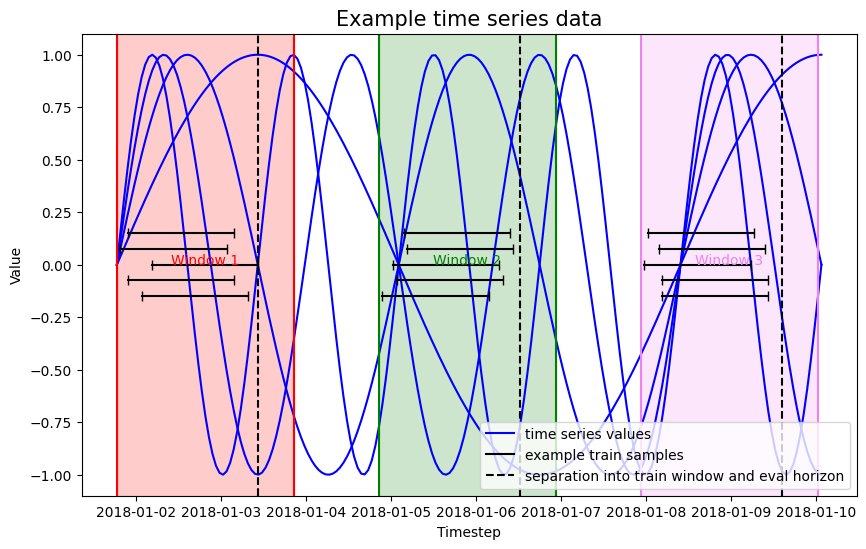

In [3]:
#################
# Visualization #
#################

plt.figure(figsize=(10, 6))
for column in df.columns:
    plt.plot(df.index, df[column], color='blue')

unit = pd.Timedelta(freq)
for i, (start, color) in enumerate(zip(window_starts, cycle(["red", "green", "violet"]))):
    plt.axvline(start, color=color, linestyle='-')
    plt.axvline(start + unit * (train_window), color='black', linestyle='--')
    plt.axvline(start + unit * (train_window + eval_window), color=color, linestyle='-')
    plt.axvspan(start, start + unit * (train_window + eval_window), color=color, alpha=0.2)
    plt.text(start + unit * (train_window + eval_window) / 2, 0, f'Window {i + 1}', color=color, ha='center')

    # plot example train samples
    for j in np.linspace(-0.15, 0.15, 5):
        r = random.randint(0, train_window - series_length - eval_window)
        r = unit * r + start      
        plt.plot([r, r + unit * (series_length + eval_window)], [j, j], color='black')
        plt.plot(r, j, marker='|', color='black', markersize=7)
        plt.plot(r + unit * (series_length + eval_window), j, marker='|', color='black', markersize=7)

plt.title('Example time series data', size=15)
plt.xlabel('Timestep', size=10)
plt.ylabel('Value', size=10)

plt.plot([], [], color='blue', label="time series values")
plt.plot([], [], color='black', label="example train samples")
plt.plot([], [], color='black', linestyle='--', label="separation into train window and eval horizon")

plt.legend(loc='lower right')
plt.show()

# Dataset and loader

In [4]:
datasets = [
    datasets.Dataset(
        data_full=datasets.DataCollection(data_loader=lambda: df),
        start_date=pd.Timestamp(start_date),
        train_window=train_window,
        eval_window=eval_window,
        series_length=series_length,
    ) for start_date in window_starts]

inputs_iterables = [
    functools.partial(
        inputs.CreateInputs,
        dataset=dataset,
        batch_size=4,
        series_length=series_length,
        weighted_sampling=True,
    ) for dataset in datasets]

# Model and predictor

In [5]:
model_body: models.TransformerBody = functools.partial(
    models.TransformerBody,
    d_model=64,
    n_layers=2,
    n_heads=2,
    max_len=100,
    dropout=0.1,
)

predictor_class: predictors.SerialPredictor = functools.partial(
    predictors.SerialPredictor,
    d_in=256,
    vocab_size=64,
    precision=3,
    significance_decay=0.7,
    low=0.0,
    high=1.0,
    normalization="per_ts",
)

# Training: Train tsGT for a few iterations

In [ ]:
loops, predictors = [], []

for inputs_iterable in inputs_iterables:
    loop, predictor = trainer.train(
        output_dir='./out',
        inputs=functools.partial(inputs_iterable, full_eval=False),
        model_body=model_body,
        predictor_class=predictor_class,
        optimizer=optimizers.Adam,
        n_steps=6,
        eval_every=2,
        n_eval_batches=1,
        calc_eval_loss=True,
    )
    loops.append(loop)
    predictors.append(predictor)

# Simulation

generate simulation data and show a dataframe

In [ ]:
import simulations


dfs_sim = [
    simulations.simulate(
        inputs_iterable=functools.partial(inputs_iterable, full_eval=True),
        weights=loop._eval_model.weights,
        predictor=predictor,
        dataset=dataset,
        n_samples=128) 
    for inputs_iterable, predictor, dataset in zip(inputs_iterables, predictors, datasets)
]

dfs_sim[0]

# Evaluate and visualize

In [ ]:
import evaluation


train_data = [dataset.train_data for dataset in datasets]

evaluation.evaluate(
    train_data=train_data,
    sim_dataframes=dfs_sim,
    output_dir="./out",
    normalize=None,
    average_preds=False,
)

Results are stored now in `./out/results/results.pkl`.

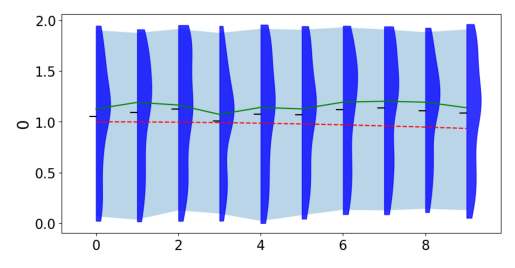

In [9]:
image = "./out/trajectories/trajectory_good_0_0.png"
img = plt.imread(image)

plt.imshow(img)
_ = plt.axis('off')